<font size="10"> Neural style trnasfer to Vang Gogh, Picasso, or Klimt style


# Importing the libraries

In [ ]:
import copy
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.utils as utils
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Data Visualization

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

imsize = 512

loader = transforms.Compose([
    transforms.Resize((imsize,imsize)),
    transforms.ToTensor()
])

def image_loader(image_name):
    # to load an image, resize it to the predefined size and
    # convert it to a PyTorch tensor
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


unloader = transforms.ToPILImage()

def imshow(tensor, title=None):
    # to take a PyTorch tensor representing the image, convert
    # it to a PIL image and display it
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


In [ ]:
# Loading images
the_scream_content_img = image_loader("/content/drive/MyDrive/My projects/Style Transfer/Style_images/The scream.jpg")
the_scream_input_img   = the_scream_content_img.clone()

japanese_footbridge_content_img = image_loader("/content/drive/MyDrive/My projects/Style Transfer/Style_images/Japanese footbridge.jpg")
japanese_footbridge_input_img   = japanese_footbridge_content_img.clone()


VG_style_img1 = image_loader("/content/drive/MyDrive/My projects/Style Transfer/Style_images/The starry night.jpg")
VG_style_img2 = image_loader("/content/drive/MyDrive/My projects/Style Transfer/Style_images/Starry night over the rhone.jpg")
VG_style_img3 = image_loader("/content/drive/MyDrive/My projects/Style Transfer/Style_images/Wheat field with cypresses.jpg")

PI_style_img1 = image_loader("/content/drive/MyDrive/My projects/Style Transfer/Style_images/Woman with watch.jpg")
PI_style_img2 = image_loader("/content/drive/MyDrive/My projects/Style Transfer/Style_images/Girl before a mirror.jpg")
PI_style_img3 = image_loader("/content/drive/MyDrive/My projects/Style Transfer/Style_images/The dream.jpg")

KL_style_img1 = image_loader("/content/drive/MyDrive/My projects/Style Transfer/Style_images/The tree of life.jpg")
KL_style_img2 = image_loader("/content/drive/MyDrive/My projects/Style Transfer/Style_images/The kiss.jpg")
KL_style_img3 = image_loader("/content/drive/MyDrive/My projects/Style Transfer/Style_images/Portrait of adele bloch-bauer.jpg")


<font size="5">Content images:

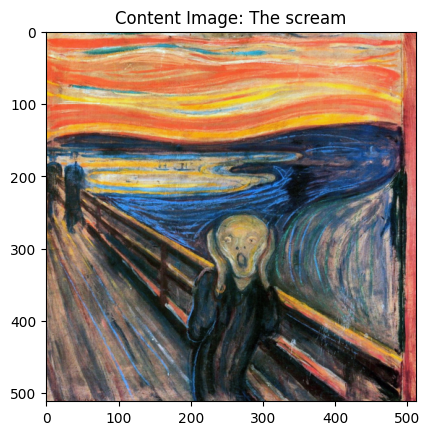

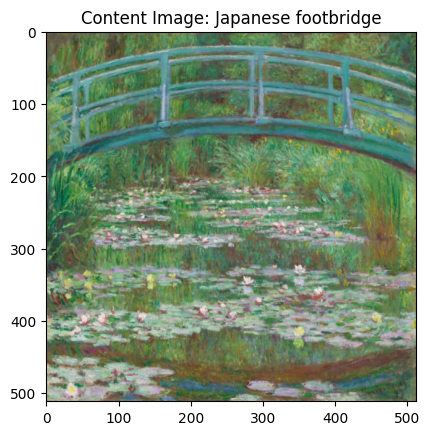

In [ ]:
plt.ion()

plt.figure()
imshow(the_scream_content_img, title='Content Image: The scream')
plt.figure()
imshow(japanese_footbridge_content_img, title='Content Image: Japanese footbridge')


<font size="5">Van Gogh images:

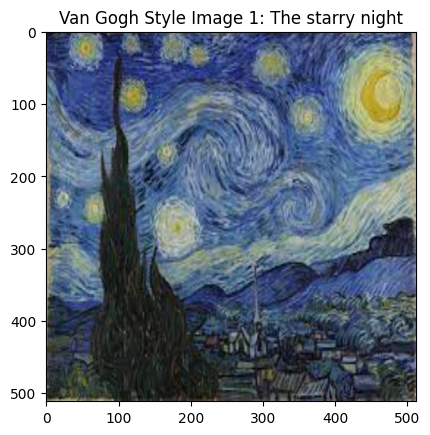

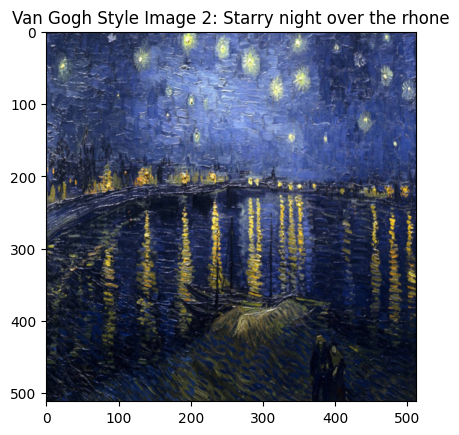

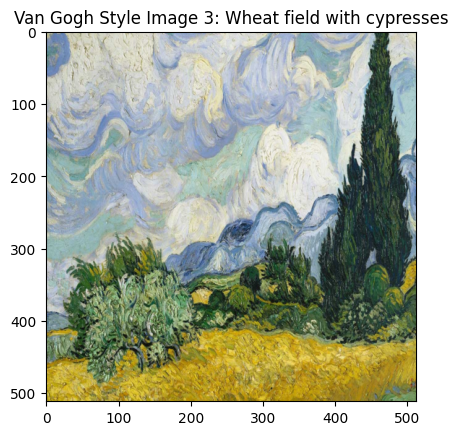

In [ ]:
plt.ion()

plt.figure()
imshow(VG_style_img1, title='Van Gogh Style Image 1: The starry night')
plt.figure()
imshow(VG_style_img2, title='Van Gogh Style Image 2: Starry night over the rhone')
plt.figure()
imshow(VG_style_img3, title='Van Gogh Style Image 3: Wheat field with cypresses')


<font size="5">Picasso images:

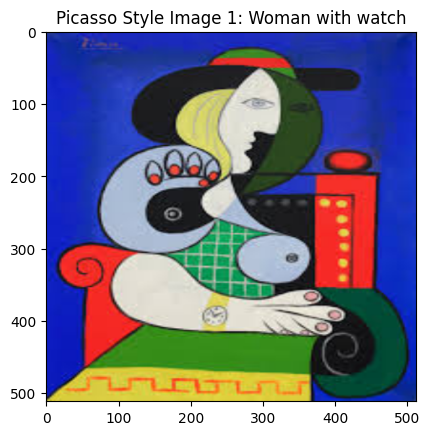

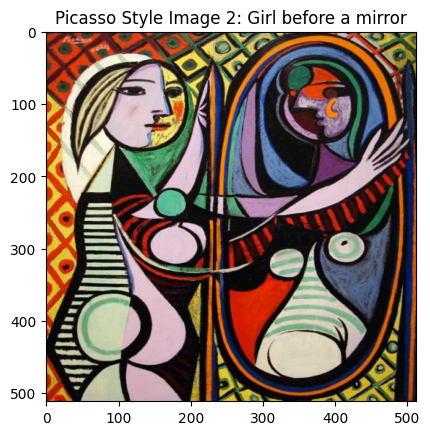

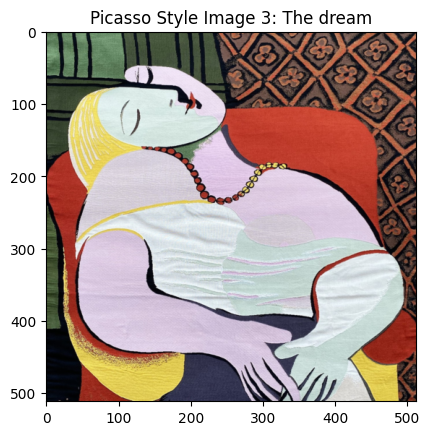

In [ ]:
plt.ion()

plt.figure()
imshow(PI_style_img1, title='Picasso Style Image 1: Woman with watch')
plt.figure()
imshow(PI_style_img2, title='Picasso Style Image 2: Girl before a mirror')
plt.figure()
imshow(PI_style_img3, title='Picasso Style Image 3: The dream')


<font size="5">Klimt images:

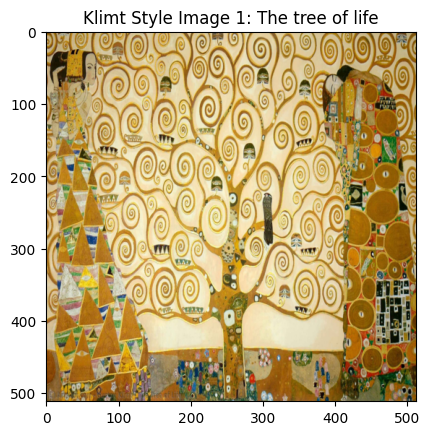

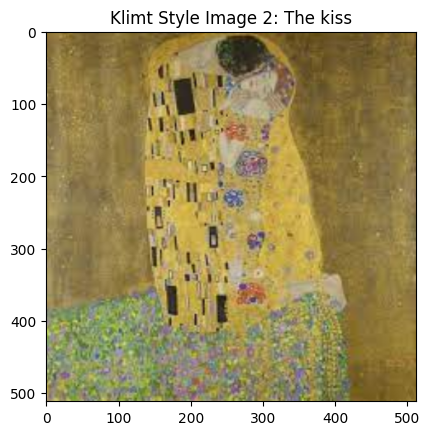

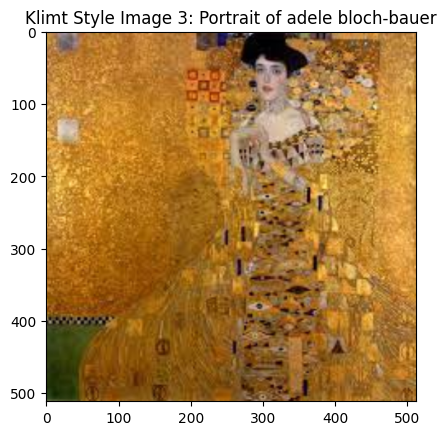

In [ ]:
plt.ion()

plt.figure()
imshow(KL_style_img1, title='Klimt Style Image 1: The tree of life')
plt.figure()
imshow(KL_style_img2, title='Klimt Style Image 2: The kiss')
plt.figure()
imshow(KL_style_img3, title='Klimt Style Image 3: Portrait of adele bloch-bauer')


# Style transfer architecture

<font size="5">Useful functions:

In [ ]:
class Normalization(nn.Module):
    # module to make sure that images have zero mean and unit variance

    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):

        return (img - self.mean) / self.std


In [ ]:
def empty_lists(input_list):
    # function to initialize a list of empty lists

    lists = []
    for i in range(len(input_list)):
        lists.append([])

    return lists


In [ ]:
def get_input_optimizer(input_img):
    # the optimizer chosen is "L-BFGS" (Limited-memory Broyden–Fletcher–Goldfarb–Shanno)

    optimizer = optim.LBFGS([input_img.requires_grad_()])

    return optimizer


In [ ]:
def pick_painter(painter, content, input, content_faithfulness= 5.5):
  # this function actually allows to customize the style of the final product

  # cntent_faithfulness is a small measure to slightly intensify or lower the
  # presence of the content reference in the final output
  if content_faithfulness >= 10:
    content_faithfulness = 10
  elif content_faithfulness <= 1:
    content_faithfulness = 1
  # setting some boundries so that no mattr what magnitude is chosen, the output
  # will stay nice and clen

  faith_multiplier = 0.8 + (content_faithfulness - 1) * (1.2 - 0.8) / 9
  # cntent_faithfulness paramete will cause, at max, a variation of 20% in the
  # ad hoc pre estabilished content weight

  if painter == "Van Gogh":
    # setting parameters for the Van Gogh style,
    # including style references, their weights and the one for the content
    style_images = [VG_style_img1, VG_style_img2, VG_style_img3]
    style_weights = [200, 150, 150]
    content_weight = 0.001 * faith_multiplier

  elif painter == "Picasso":
    # setting parameters for the Picasso style,
    # including style references, their weights and the one for the content
    style_images = [PI_style_img1, PI_style_img2, PI_style_img3]
    style_weights = [200, 150, 150]
    content_weight = 0.002 * faith_multiplier

  elif painter == "Klimt":
    # setting parameters for the Klimt style,
    # including style references, their weights and the one for the content
    style_images = [KL_style_img1, KL_style_img2, KL_style_img3]
    style_weights = [150, 150, 200]
    content_weight = 0.0003 * faith_multiplier

  optimizer = get_input_optimizer(input)
  input_image = input
  content_image = content

  return style_images, content_image, input_image, style_weights, content_weight, optimizer


In [ ]:
def getPreTrainedNN():
    # function to get the model, in this case VGG19

    cnn = models.vgg19(pretrained=True).features.to(device).eval()

    return cnn


<font size="5">Defining the losses:

In [ ]:
class ContentLoss(nn.Module):
    # content loss is computed as the MSE between feature maps

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)

        return input


In [ ]:
def gram_matrix(input):
    # function to compute the gram matrix from a tensor, which is a
    # rappresentation of the style

    a, b, c, d = input.size()
    # a = batch size, b = number of feature maps
    # (c,d) = dimensions of a feature map
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())

    return G.div(a * b * c * d)


In [ ]:
class StyleLoss(nn.Module):
    # style loss is computed as the MSE between gram matrices

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)

        return input


<font size="5">Creating the style transfer model:

In [ ]:
def get_style_model_and_losses(cnn,
                               normalization_mean,
                               normalization_std,
                               style_images,
                               content_img,
                               content_layers=None,
                               style_layers=None):

    cnn = copy.deepcopy(cnn)

    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # Empty list to store content losses during the style transfer process
    content_losses = []
    # List of empty lists lo store style losses for each style image
    style_loss_lists = empty_lists(style_images)

    model = nn.Sequential(normalization)

    i = 0

    ### CREATING THE STYLE TRANSFER MODEL

    for layer in cnn.children():
        # adding tho the model the layers from the chosen starting model

        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)


        if name in content_layers:
            # adding the content loss layer in the chosen place

            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)


        if name in style_layers:
            # adding the style loss layer in the chosen place

            target_features = [model(style_img).detach() for style_img in style_images]
            style_loss = [StyleLoss(feature) for feature in target_features]
            # computing the style loss for each style reference (based on the convolutional layer features)

            for j in range(len(style_images)):
              # creating a style loss layer for each style reference
              module_name = "style_loss_"
              module_name += str(j)
              module_name += str({})
              model.add_module(module_name.format(i), style_loss[j])

            for k in range(len(style_images)):
              # at each style layer the style loss computed on the appropriate style reference
              # is appended to the appropriate list inside big style loss list
              style_loss_lists[k].append(style_loss[k])

    for i in range(len(model) - 1, -1, -1):
      # layers after the last content/style loss computation can be trimmed off
      # without riprcussions

        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_loss_lists, content_losses


<font size="5">Performing style transfer (gradient descent):

In [ ]:
def run_style_transfer(cnn,
                       normalization_mean,
                       normalization_std,
                       content_img,
                       style_images,
                       input_img,
                       style_weight,
                       content_weight,
                       num_steps=300,
                       content_layers=None,
                       style_layers=None,
                       optimizer=None):

    """Run the style transfer."""
    print('Building the style transfer model..')

    # Initialization of the style transfer model
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
                                                                     normalization_mean,
                                                                     normalization_std,
                                                                     style_images,
                                                                     content_img,
                                                                     content_layers,
                                                                     style_layers)

    print('Optimizing..')

    # Optimization setup
    run = [0]
    while run[0] <= num_steps:

        def closure():

            input_img.data.clamp_(0, 1)

            # Clears the gradients of the input image tensor to prepare for a new optimization step
            optimizer.zero_grad()

            # Runs the style transfer model on the input image to compute style and content losses
            model(input_img)

            style_score = 0
            content_score = 0

            for sl in zip(*style_losses):
                # for each list of style losses in the big list, which is associated to
                # a style reference, and contains the style losses computed at all the style loss layers
                for i in range(len(style_images)):
                  # a style score is compute summing all the losses values computed in the step:
                  # First each style loss is scaled by the style weight of its reference and by the number of style loss layers
                  # Then all the style losses are summed to get a style score that is valid for the hwhole step (epoch)
                  style_score += (style_weight[i] / len(style_layers)) * sl[i].loss

            for cl in content_losses:
                # the content score is a measure of the content loss in the whole step, and is computed
                # by summing the content losses at each content loss layer, scaled by the number of layers
                content_score += cl.loss/len(content_layers)

            # the content score is scaled by the content weight as well
            content_score *= content_weight

            # the total loss is computed as the sum of the content score and the style score
            loss = style_score + content_score

            # backpropagation
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)
        # updating the parameters of the model, based on gradients computed during the backprop

    input_img.data.clamp_(0, 1)

    return input_img


# Running the style transfer

<font size="5"> Defining parameters:

In [ ]:
# setting some hyperparameters
content_layers_default = ['conv_4']
style_layers_default   = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)


<font size="5">Van Gogh style transfer on The Scream:

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 85.7MB/s]


Building the style transfer model..


<ipython-input-8-8416bcbd5232>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-8-8416bcbd5232>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [50]:
Style Loss : 0.280331 Content Loss: 0.007188

run [100]:
Style Loss : 0.277069 Content Loss: 0.006079

run [150]:
Style Loss : 0.276691 Content Loss: 0.005719

run [200]:
Style Loss : 0.276519 Content Loss: 0.005544

run [250]:
Style Loss : 0.276419 Content Loss: 0.005449

run [300]:
Style Loss : 0.276360 Content Loss: 0.005389



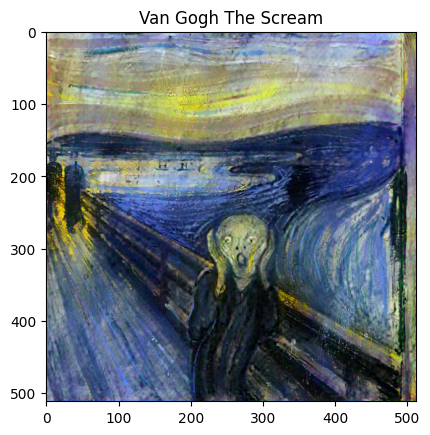

In [ ]:
# perforing style trandfer on The Scream (Munch), imposing Van Gogh style

cnn = getPreTrainedNN()
cnn.eval()

style_images, content_image, input_image, style_weights, content_weight, optimizer = pick_painter("Van Gogh", the_scream_content_img, the_scream_input_img)

output = run_style_transfer(cnn,
                            cnn_normalization_mean,
                            cnn_normalization_std,
                            content_image,
                            style_images,
                            input_image,
                            style_weight=style_weights,
                            content_weight=content_weight,
                            num_steps=300,
                            content_layers=content_layers_default,
                            style_layers=style_layers_default,
                            optimizer=optimizer)

plt.figure()
imshow(output, title='Van Gogh The Scream')

numpy_image = output.detach().cpu().numpy()
numpy_image = np.squeeze(numpy_image)
numpy_image = np.transpose(numpy_image, (1, 2, 0))
pil_image = Image.fromarray((numpy_image * 255).astype(np.uint8))
pil_image.save("/content/drive/MyDrive/My projects/Style Transfer/Output images/Van Gogh - The Scream.jpg")

plt.ioff()
plt.show()


<font size="5">Picasso style transfer on The Scream:

Building the style transfer model..
Optimizing..


<ipython-input-8-8416bcbd5232>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-8-8416bcbd5232>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 0.792823 Content Loss: 0.024147

run [100]:
Style Loss : 0.778330 Content Loss: 0.020136

run [150]:
Style Loss : 0.774965 Content Loss: 0.018361

run [200]:
Style Loss : 0.773979 Content Loss: 0.017429

run [250]:
Style Loss : 0.773646 Content Loss: 0.016954

run [300]:
Style Loss : 0.784813 Content Loss: 0.018680



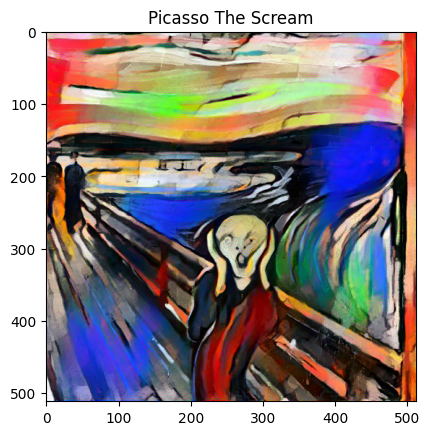

In [ ]:
# perforing style trandfer on The Scream (Munch), imposing Picasso style

cnn = getPreTrainedNN()
cnn.eval()

style_images, content_image, input_image, style_weights, content_weight, optimizer = pick_painter("Picasso", the_scream_content_img, the_scream_input_img)

output = run_style_transfer(cnn,
                            cnn_normalization_mean,
                            cnn_normalization_std,
                            content_image,
                            style_images,
                            input_image,
                            style_weight=style_weights,
                            content_weight=content_weight,
                            num_steps=300,
                            content_layers=content_layers_default,
                            style_layers=style_layers_default,
                            optimizer=optimizer)


plt.figure()
imshow(output, title='Picasso The Scream')

numpy_image = output.detach().cpu().numpy()
numpy_image = np.squeeze(numpy_image)
numpy_image = np.transpose(numpy_image, (1, 2, 0))
pil_image = Image.fromarray((numpy_image * 255).astype(np.uint8))
pil_image.save("/content/drive/MyDrive/My projects/Style Transfer/Output images/Picasso - The Scream.jpg")

plt.ioff()
plt.show()


<font size="5">Klimt style transfer on The Scream:

Building the style transfer model..
Optimizing..


<ipython-input-8-8416bcbd5232>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-8-8416bcbd5232>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 0.836622 Content Loss: 0.006539

run [100]:
Style Loss : 0.832392 Content Loss: 0.004722

run [150]:
Style Loss : 0.831504 Content Loss: 0.003860

run [200]:
Style Loss : 0.831161 Content Loss: 0.003462

run [250]:
Style Loss : 0.831016 Content Loss: 0.003240

run [300]:
Style Loss : 0.830952 Content Loss: 0.003093



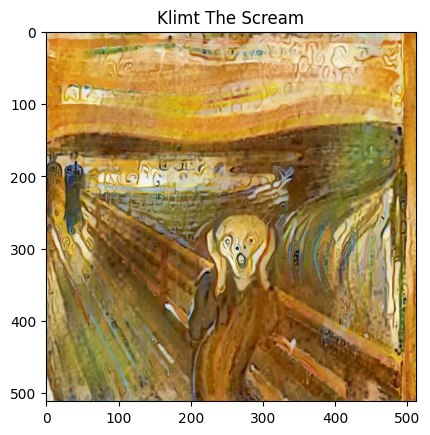

In [ ]:
# perforing style trandfer on The Scream (Munch), imposing Kimt style

cnn = getPreTrainedNN()
cnn.eval()

style_images, content_image, input_image, style_weights, content_weight, optimizer = pick_painter("Klimt", the_scream_content_img, the_scream_input_img)

output = run_style_transfer(cnn,
                            cnn_normalization_mean,
                            cnn_normalization_std,
                            content_image,
                            style_images,
                            input_image,
                            style_weight=style_weights,
                            content_weight=content_weight,
                            num_steps=300,
                            content_layers=content_layers_default,
                            style_layers=style_layers_default,
                            optimizer=optimizer)


plt.figure()
imshow(output, title='Klimt The Scream')

numpy_image = output.detach().cpu().numpy()
numpy_image = np.squeeze(numpy_image)
numpy_image = np.transpose(numpy_image, (1, 2, 0))
pil_image = Image.fromarray((numpy_image * 255).astype(np.uint8))
pil_image.save("/content/drive/MyDrive/My projects/Style Transfer/Output images/Klimt - The Scream.jpg")

plt.ioff()
plt.show()


<font size="5">Van Gogh style transfer on Japanese footbridge:

Building the style transfer model..
Optimizing..


<ipython-input-8-8416bcbd5232>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-8-8416bcbd5232>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 0.280611 Content Loss: 0.006536

run [100]:
Style Loss : 0.278035 Content Loss: 0.005396

run [150]:
Style Loss : 0.277085 Content Loss: 0.005016

run [200]:
Style Loss : 0.276692 Content Loss: 0.004764

run [250]:
Style Loss : 0.276499 Content Loss: 0.004649

run [300]:
Style Loss : 0.276383 Content Loss: 0.004609



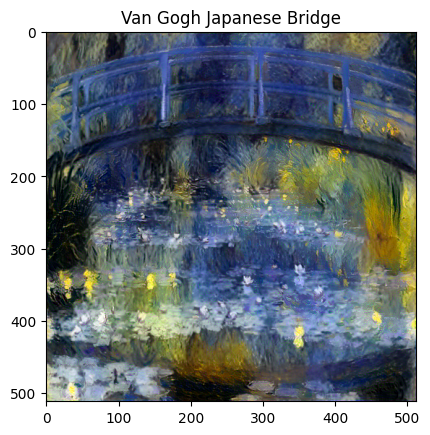

In [ ]:
# perforing style trandfer on Japanese footbridge (Monet), imposing Van Gogh style

cnn = getPreTrainedNN()
cnn.eval()

style_images, content_image, input_image, style_weights, content_weight, optimizer = pick_painter("Van Gogh", japanese_footbridge_content_img, japanese_footbridge_input_img)

output = run_style_transfer(cnn,
                            cnn_normalization_mean,
                            cnn_normalization_std,
                            content_image,
                            style_images,
                            input_image,
                            style_weight=style_weights,
                            content_weight=content_weight,
                            num_steps=300,
                            content_layers=content_layers_default,
                            style_layers=style_layers_default,
                            optimizer=optimizer)


plt.figure()
imshow(output, title='Van Gogh Japanese Bridge')

numpy_image = output.detach().cpu().numpy()
numpy_image = np.squeeze(numpy_image)
numpy_image = np.transpose(numpy_image, (1, 2, 0))
pil_image = Image.fromarray((numpy_image * 255).astype(np.uint8))
pil_image.save("/content/drive/MyDrive/My projects/Style Transfer/Output images/Van Gogh - Japanese Footbridge.jpg")

plt.ioff()
plt.show()

<font size="5">Picasso style transfer on Japanese bridge:

Building the style transfer model..
Optimizing..


<ipython-input-8-8416bcbd5232>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-8-8416bcbd5232>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 0.795119 Content Loss: 0.028669

run [100]:
Style Loss : 0.779687 Content Loss: 0.025733

run [150]:
Style Loss : 0.775868 Content Loss: 0.023864

run [200]:
Style Loss : 0.774648 Content Loss: 0.022907

run [250]:
Style Loss : 0.774289 Content Loss: 0.022398

run [300]:
Style Loss : 0.774252 Content Loss: 0.022242



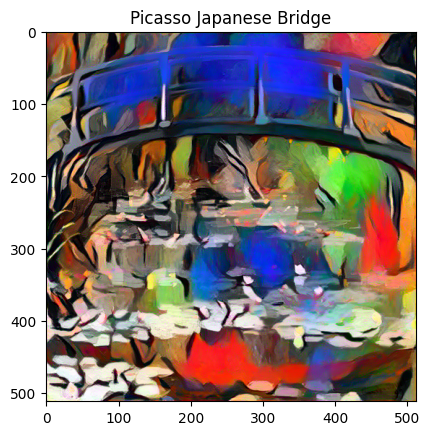

In [ ]:
# perforing style trandfer on Japanese footbridge (Monet), imposing Picasso style

cnn = getPreTrainedNN()
cnn.eval()

style_images, content_image, input_image, style_weights, content_weight, optimizer = pick_painter("Picasso", japanese_footbridge_content_img, japanese_footbridge_input_img)

output = run_style_transfer(cnn,
                            cnn_normalization_mean,
                            cnn_normalization_std,
                            content_image,
                            style_images,
                            input_image,
                            style_weight=style_weights,
                            content_weight=content_weight,
                            num_steps=300,
                            content_layers=content_layers_default,
                            style_layers=style_layers_default,
                            optimizer=optimizer)


plt.figure()
imshow(output, title='Picasso Japanese Bridge')

numpy_image = output.detach().cpu().numpy()
numpy_image = np.squeeze(numpy_image)
numpy_image = np.transpose(numpy_image, (1, 2, 0))
pil_image = Image.fromarray((numpy_image * 255).astype(np.uint8))
pil_image.save("/content/drive/MyDrive/My projects/Style Transfer/Output images/Picasso - Japanese Footbridge.jpg")

plt.ioff()
plt.show()

<font size="5">Klimt style transfer on Japanese footbridge:

Building the style transfer model..
Optimizing..


<ipython-input-8-8416bcbd5232>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-8-8416bcbd5232>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 0.837460 Content Loss: 0.005838

run [100]:
Style Loss : 0.832292 Content Loss: 0.004057

run [150]:
Style Loss : 0.831342 Content Loss: 0.003276

run [200]:
Style Loss : 0.831038 Content Loss: 0.002869

run [250]:
Style Loss : 0.830936 Content Loss: 0.002649

run [300]:
Style Loss : 0.830884 Content Loss: 0.002512



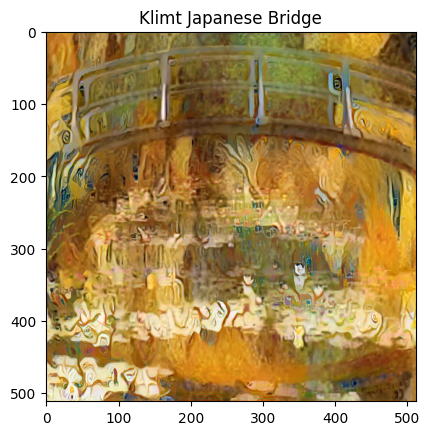

In [ ]:
# perforing style trandfer on Japanese footbridge (Monet), imposing Klimt style

cnn = getPreTrainedNN()
cnn.eval()

style_images, content_image, input_image, style_weights, content_weight, optimizer = pick_painter("Klimt", japanese_footbridge_content_img, japanese_footbridge_input_img)

output = run_style_transfer(cnn,
                            cnn_normalization_mean,
                            cnn_normalization_std,
                            content_image,
                            style_images,
                            input_image,
                            style_weight=style_weights,
                            content_weight=content_weight,
                            num_steps=300,
                            content_layers=content_layers_default,
                            style_layers=style_layers_default,
                            optimizer=optimizer)


plt.figure()
imshow(output, title='Klimt Japanese Bridge')

numpy_image = output.detach().cpu().numpy()
numpy_image = np.squeeze(numpy_image)
numpy_image = np.transpose(numpy_image, (1, 2, 0))
pil_image = Image.fromarray((numpy_image * 255).astype(np.uint8))
pil_image.save("/content/drive/MyDrive/My projects/Style Transfer/Output images/Klimt - Japanese Footbridge.jpg")

plt.ioff()
plt.show()